# Cleaning Modes With Rational Filters

In [166]:
# Don't understand how srate affects SNR
# srate affects Bayes in a systematic way but not with too much impact

In [43]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [44]:
import matplotlib.pyplot as pl
import numpy as np
import qnm_filter
import qnm
from gwpy.timeseries import TimeSeries
import copy
from scipy.special import logsumexp
import astropy.constants as c

## Data

In [45]:
theoretical_values = [50, 0.69]

In [46]:
omega, A, C = qnm.modes_cache(s=-2, l=2, m=2, n=0)(a=theoretical_values[1])
T_MSUN = c.M_sun.value * c.G.value / c.c.value**3

In [47]:
srate = 4096*2
t_range_prepad = np.linspace(0,0.5, int(srate/2), endpoint = False)
heaviside = np.heaviside(t_range_prepad, 1)
temp = 1e-22*np.exp(-1j*omega*t_range_prepad/(theoretical_values[0]*T_MSUN))
signal_prepad = np.real(temp*heaviside)
t_range = np.linspace(0,1, srate, endpoint = False)
signal = np.pad(signal_prepad, (int(srate/4),int(srate/4)))
noise = 1e-23*np.random.normal(size = srate)

(0.245, 0.265)

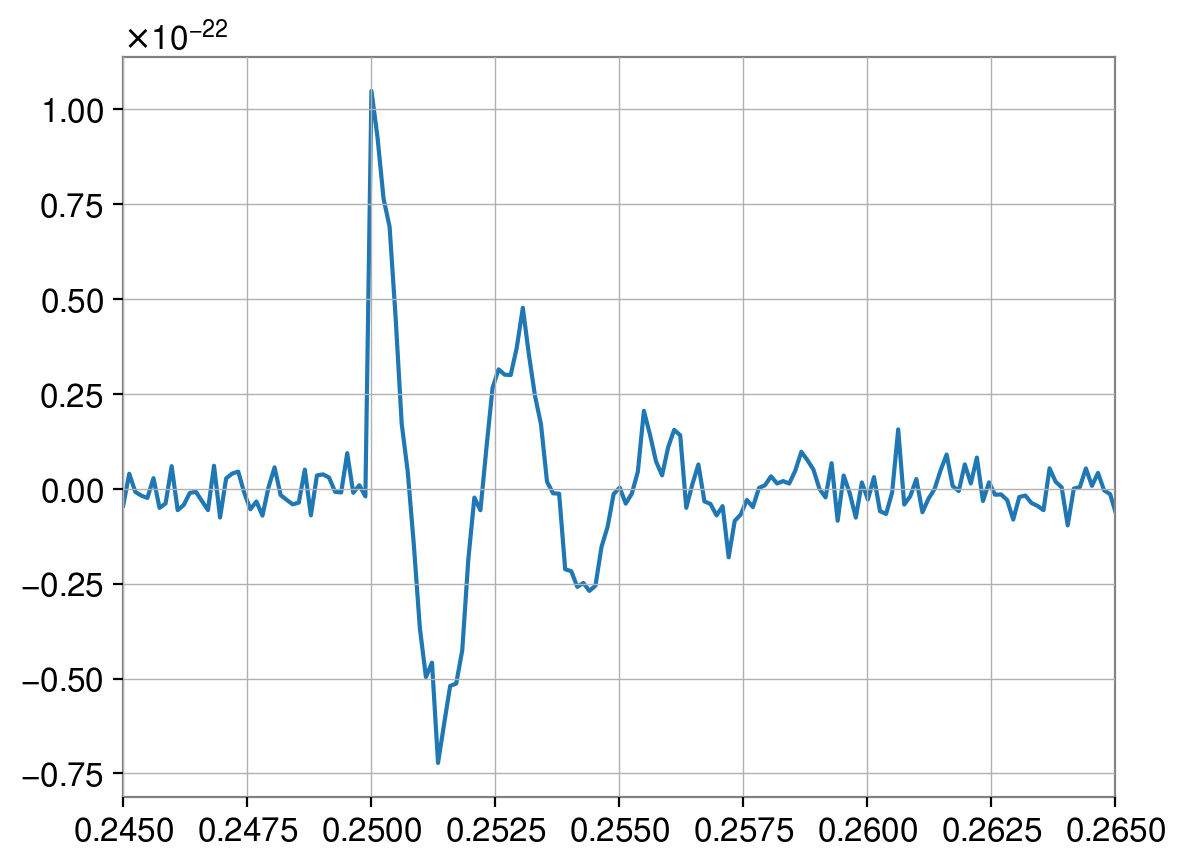

In [48]:
data = signal + .5*noise
pl.plot(t_range, data)
pl.xlim(0.245, 0.265)

## Filter

In [49]:
mass = qnm_filter.Filter.mass_unit(50)

In [58]:
input = dict(model_list = [(2,2,0, 'p')], #l, m, n
             # trucation time (geocenter, in second)
             t_init = 0.25+3*mass, #Calculated from SNR+t_init notebook
             # length of the analysis window (in second)
             segment_length = 0.2,
             # sampling rate after conditioning (in Hz)
             srate = 4096,
             # sky localization
             ra = None, dec = None,
             # lower limit of the high-pass filter (in Hz)
             flow = 20)

fit = qnm_filter.Network(**input)

Load data

In [59]:
fit.original_data['H1'] = qnm_filter.RealData(data, index = t_range)
fit.detector_alignment()
fit.condition_data('original_data', **input, trim = 0.0)
fit.compute_acfs('original_data')
fit.cholesky_decomposition()
fit.first_index()

In [60]:
fit_temp = qnm_filter.Network(**input)
fit_temp.original_data['H1'] = qnm_filter.RealData(signal, index = t_range)
fit_temp.detector_alignment()
fit_temp.condition_data('original_data', **input, trim = 0.0)
fit_temp.compute_acfs('original_data')
fit_temp.cholesky_decomposition()
fit_temp.first_index()
data = fit.truncate_data(fit.original_data)['H1']
template = fit_temp.truncate_data(fit_temp.original_data)['H1']

In [61]:
fit.compute_SNR(data, template, 'H1', optimal=False)

22.66664062662253

In [62]:
scaling_arr = np.linspace(0.1, 3, 50)
realisation_SNR = []
realisation_bayes = []

for i in range(4):
    noise = 1e-23*np.random.normal(size = srate)
    SNR_arr = []
    bayes_arr = []
    for j in scaling_arr:
        data = signal + j*noise

        fit = qnm_filter.Network(**input)
        fit.original_data['H1'] = qnm_filter.RealData(data, index = t_range)
        fit.detector_alignment()
        fit.condition_data('original_data', **input, trim = 0.0)
        fit.compute_acfs('original_data')
        fit.cholesky_decomposition()
        fit.first_index()

        fit_temp = qnm_filter.Network(**input)
        fit_temp.original_data['H1'] = qnm_filter.RealData(signal, index = t_range)
        fit_temp.detector_alignment()
        fit_temp.condition_data('original_data', **input, trim = 0.0)
        fit_temp.compute_acfs('original_data')
        fit_temp.cholesky_decomposition()
        fit_temp.first_index()
        data = fit.truncate_data(fit.original_data)['H1']
        template = fit_temp.truncate_data(fit_temp.original_data)['H1']

        SNR = fit.compute_SNR(data, template, 'H1', optimal=False)
        fit.compute_likelihood(apply_filter = False)
        fit.add_filter(mass = 50, chi = 0.5, model_list = [(2,2,0,'p')])
        Bayes = fit.compute_likelihood() - fit.compute_likelihood(apply_filter=False)

        bayes_arr.append(Bayes)
        SNR_arr.append(SNR)
    realisation_SNR.append(SNR_arr)
    realisation_bayes.append(bayes_arr)

Text(0, 0.5, '$\\log_{10}$(ln(Bayes factor))')

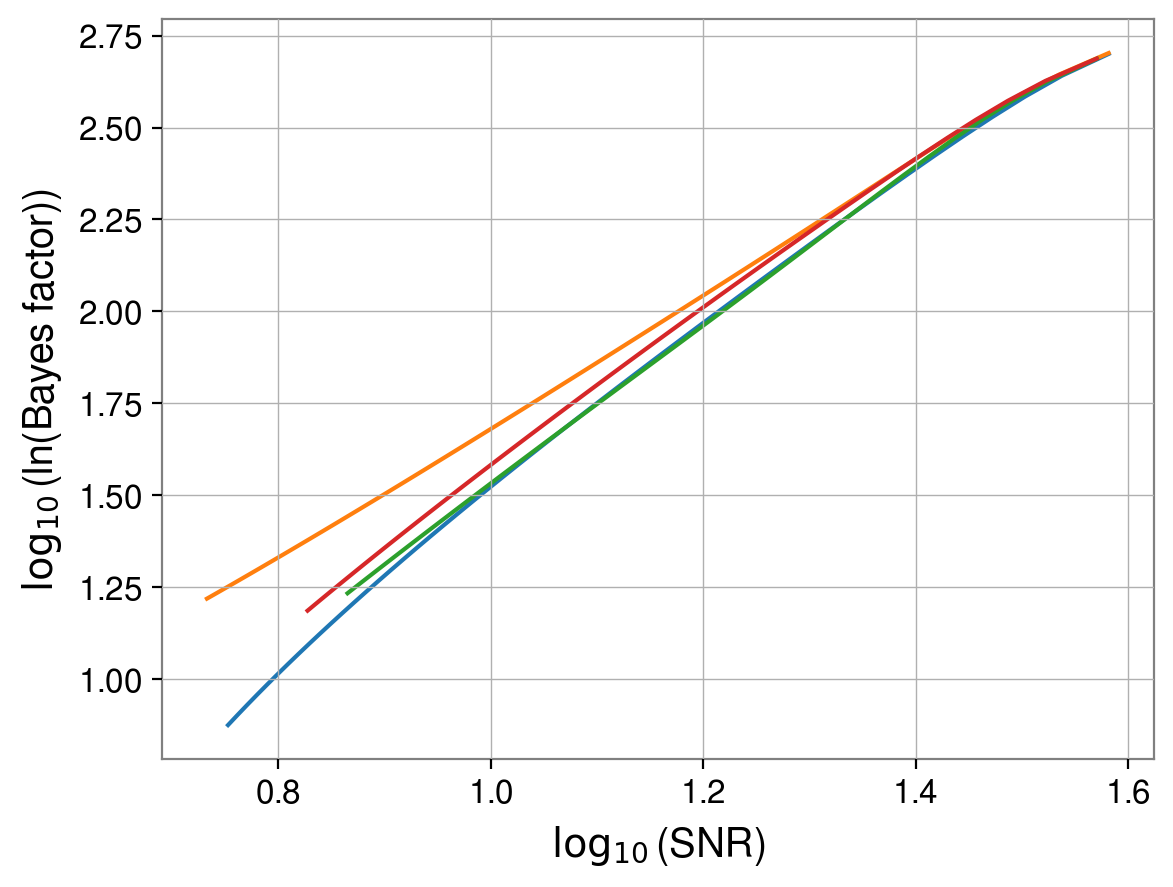

In [63]:
for i, val in enumerate(realisation_SNR):
    pl.plot(np.log10(val), np.log10(realisation_bayes[i]))
pl.xlabel(r'$\log_{10}$(SNR)')
pl.ylabel(r'$\log_{10}$(ln(Bayes factor))')
# pl.xlim(0.8, 1.45)

In [ ]:
np.polyfit(np.log10(realisation_SNR[0]), np.log10(np.log10(np.exp(realisation_bayes[0]))), deg=1, cov = True)

## Effect of srate

In [107]:
temp_input = dict(model_list = [(2,2,0, 'p')], #l, m, n
             # trucation time (geocenter, in second)
             t_init = 0.25+3*mass, #Calculated from SNR+t_init notebook
             # length of the analysis window (in second)
             segment_length = 0.2,
             # sky localization
             ra = None, dec = None,
             # lower limit of the high-pass filter (in Hz)
             flow = 20)

In [108]:
fit8K = qnm_filter.Network(srate = 4096*2, **temp_input)
fit8K.original_data['H1'] = qnm_filter.RealData(data, index = t_range)
fit8K.detector_alignment()
fit8K.condition_data('original_data', **input, trim = 0.0)
fit8K.compute_acfs('original_data')
fit8K.cholesky_decomposition()
fit8K.first_index()

fit8K.compute_likelihood(apply_filter = False)
fit8K.add_filter(mass = 50, chi = 0.5, model_list = [(2,2,0,'p')])
fit8K.compute_likelihood() - fit8K.compute_likelihood(apply_filter=False)

25.937362585180722

In [109]:
fit4K = qnm_filter.Network(srate = 4096, **temp_input)
fit4K.original_data['H1'] = qnm_filter.RealData(data, index = t_range)
fit4K.detector_alignment()
fit4K.condition_data('original_data', **input, trim = 0.0)
fit4K.compute_acfs('original_data')
fit4K.cholesky_decomposition()
fit4K.first_index()

fit4K.compute_likelihood(apply_filter = False)
fit4K.add_filter(mass = 50, chi = 0.5, model_list = [(2,2,0,'p')])
fit4K.compute_likelihood() - fit4K.compute_likelihood(apply_filter=False)

25.263713332608518

In [113]:
data8k = fit8K.truncate_data(fit8K.original_data)['H1']
SNR8K = fit8K.compute_SNR(None, data8k, ifo = 'H1', optimal = True)

data4k = fit4K.truncate_data(fit4K.original_data)['H1']
SNR4K = fit4K.compute_SNR(None, data4k, ifo = 'H1', optimal = True)

In [114]:
print(SNR8K)
print(SNR4K)
print(np.sqrt(2)*SNR4K)

40.923961580908994
29.345859949078303
41.50131313948796


In [179]:
realisation_no = 5
scaling_no = 50
scaling_arr = np.linspace(0.1, 3, scaling_no)

bayes4k_arr = np.empty((realisation_no, scaling_no))
bayes8k_arr = np.empty((realisation_no, scaling_no))
snr4k_arr = np.empty((realisation_no, scaling_no))
snr8k_arr = np.empty((realisation_no, scaling_no))

for i in range(realisation_no):
    noise = 1e-23*np.random.normal(size = srate)
    for j, scale in enumerate(scaling_arr):
        data = signal + scale*noise

        fit4K = qnm_filter.Network(srate = 4096, **temp_input)
        fit4K.original_data['H1'] = qnm_filter.RealData(data, index = t_range)
        fit4K.detector_alignment()
        fit4K.condition_data('original_data', **input, trim = 0.0)
        fit4K.compute_acfs('original_data')
        fit4K.cholesky_decomposition()
        fit4K.first_index()
        data4k = fit4K.truncate_data(fit4K.original_data)['H1']
        SNR4K = fit4K.compute_SNR(None, data4k, ifo = 'H1', optimal = True)
        snr4k_arr[i,j] = SNR4K

        fit4K.compute_likelihood(apply_filter = False)
        fit4K.add_filter(mass = 50, chi = 0.5, model_list = [(2,2,0,'p')])
        bayes4k = fit4K.compute_likelihood() - fit4K.compute_likelihood(apply_filter=False)
        bayes4k_arr[i,j] = bayes4k

        fit8K = qnm_filter.Network(srate = 4096*2, **temp_input)
        fit8K.original_data['H1'] = qnm_filter.RealData(data, index = t_range)
        fit8K.detector_alignment()
        fit8K.condition_data('original_data', **input, trim = 0.0)
        fit8K.compute_acfs('original_data')
        fit8K.cholesky_decomposition()
        fit8K.first_index()
        data8k = fit8K.truncate_data(fit8K.original_data)['H1']
        SNR8K = fit8K.compute_SNR(None, data8k, ifo = 'H1', optimal = True)
        snr8k_arr[i,j] = SNR8K

        fit8K.compute_likelihood(apply_filter = False)
        fit8K.add_filter(mass = 50, chi = 0.5, model_list = [(2,2,0,'p')])
        bayes8K = fit8K.compute_likelihood() - fit8K.compute_likelihood(apply_filter=False)
        bayes8k_arr[i,j] = bayes8K

In [180]:
# for i in range(realisation_no):
#     pl.plot(scaling_arr, bayes4k_arr[i])
#     pl.plot(scaling_arr, bayes8k_arr[i])

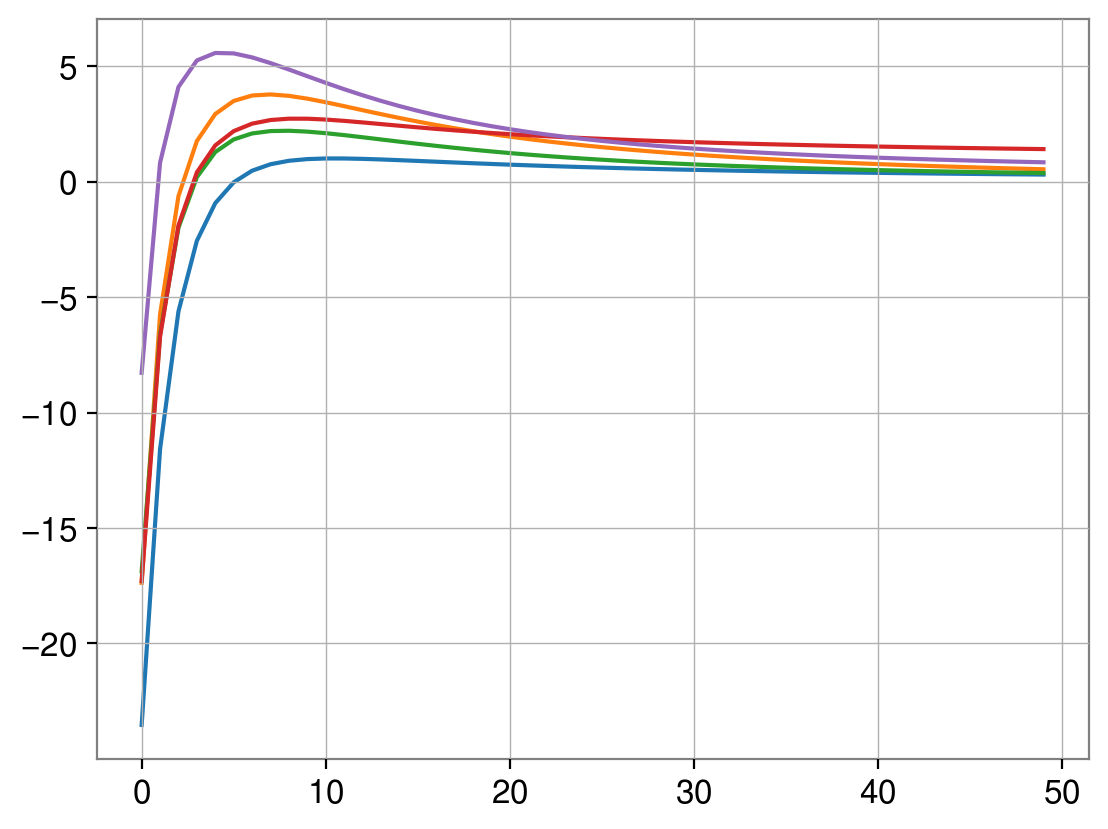

In [181]:
for i in range(realisation_no):
    pl.plot(np.subtract(bayes8k_arr[i],bayes4k_arr[i]))

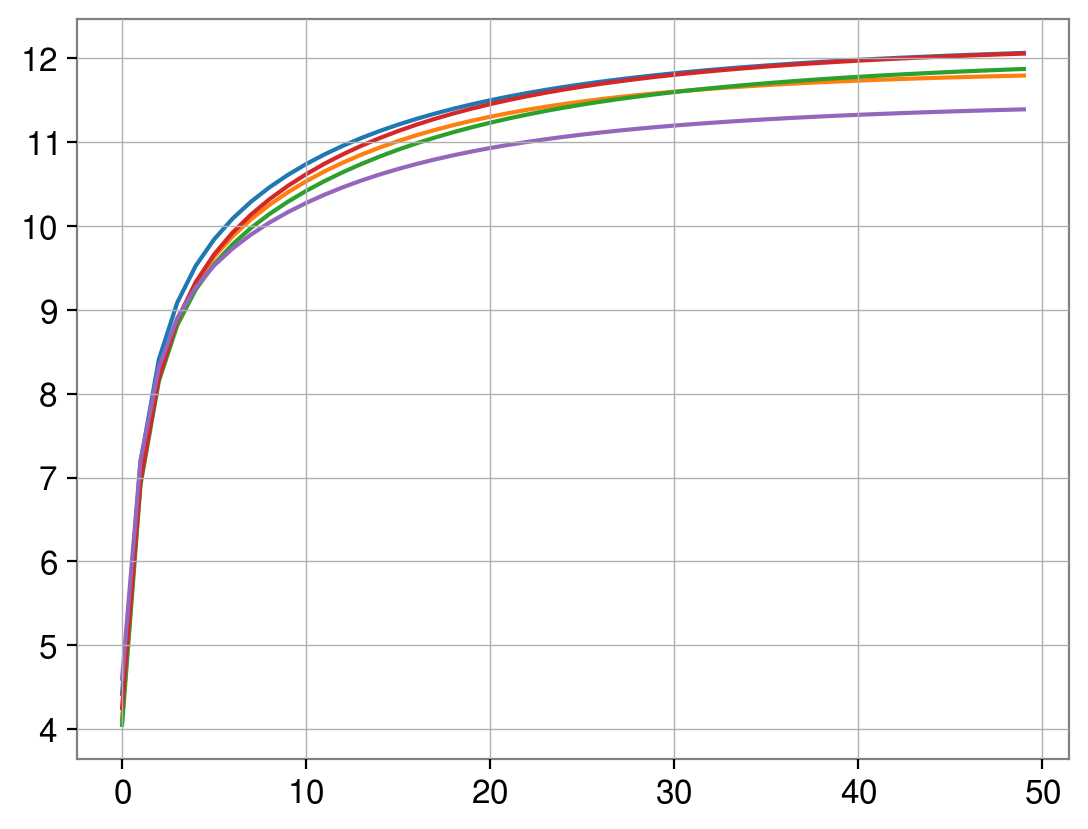

In [182]:
for i in range(realisation_no):
    pl.plot(np.subtract(snr8k_arr[i],snr4k_arr[i]))